In [34]:
import matplotlib.pylab as plt
import numpy as np

------------------
-------------
--------------
-------------
-----------
# Automate finding Ztop and Zbot and make it more general

In [9]:
#Slab class
class Slab:
    def __init__(self, rho, v, d, A = np.nan):
        self.rho = rho #density
        self.v = v     #velocity
        self.d = d     #thickness
        self.A = A     #Area
        
        if not np.isnan(A):
            self.Z = rho * v * A 
        else: 
            print("Warning: The acoustic impedance is yet undefined, since you supplied no area")
        
    def k(self,omega):
        return omega/self.v

In [10]:
#Function which creates the transfer matrix to compute new values of F,v
def M(slab,omega):
    '''
    Function which returns the transfer matrix M as a function of the slab and frequency
    
    Parameters 
    --------------
    slab: object of type Slab
        slab which seperates the states F1,v1 and F2,v2
        
    omega: float
        Frequency
        
    Returns
    -------------
    M: 2D array
        Transfer matrix
    
    '''
    #Extract variables from the slab
    k = slab.k(omega) #wave vector
    d = slab.d #thickness
    Z = slab.Z #Acoustic impedance
    
    #Compute the transfer matrix
    M = np.array([[np.cos(k*d), 1j*Z*k*d],[1j*np.sin(k*d)/Z, np.cos(k*d)]])
    
    return M

In [11]:
#Find the impedance for either free or fixed boundary conditions
def find_Z_specialBC(slabs,omega,free):
    #initialze the slabs matrix transfer
    Mslabs = np.eye(2)
    
    #Loop over the slabs
    for i in range(len(slabs)):
    
        #calculate the matrix of slab i
        Mslab = M(slabs[i],omega)
        
        #use it to update the total slabs matrix
        Mslabs = np.dot(Mslabs,Mslab)
    
    #free boundary condition
    if free:
        Z = Mslabs[0,1] / Mslabs[1,1]
        
    #fixed boundary condition
    if not free:
        Z = Mslabs[0,0] / Mslabs[1,0]
        
    return Z
    
    

In [12]:
def calculate_Zin(piezo,Zbot,Ztop,omega):
    '''Function which inputs the impedances at the top and bottom and calculates the
    input impedance Z_in = V/I'''
    #Extract all properties from the piezo to give simple names
    k = piezo.k(omega)
    d = piezo.d
    eps = piezo.eps
    
    #calculate the intrinsic capacitance of the piezoelectric actuator
    C0 = piezo.A * eps / d
    
    #normalize the top and bottom impedances using the 
    ztop = Ztop / piezo.Z
    zbot = Zbot / piezo.Z
    
    #first calculate prefactor
    prefac = 1/(1j*omega*C0) 
    
    #Calculate the term in numerator
    numerator = (ztop + zbot)*np.sin(k*d) + 2j * (1-np.cos(k*d)) 
    denominator = (ztop + zbot) * np.cos(k*d) + 1j * (1 + zbot*ztop) * np.sin(k*d) 
    
    
    Z_in = prefac * (1  - (piezo.kt/(k*d) * numerator/denominator))

    return Z_in

In [13]:
def get_s11(omega,slabs_down,piezo,slabs_up,Z0,free = True):
    
    #calculate Ztop and Zbot
    Ztop = find_Z_specialBC(slabs_up,omega,free)
    Zbot = find_Z_specialBC(slabs_down,omega,free)
    
    #calculate input impedance
    Z_in = calculate_Zin(piezo,Zbot,Ztop,omega)
    
    #calculate s11
    s11 = (Z0 - Z_in) / (Z0 + Z_in)
    
    return s11

In [14]:
#First create the slab properties

#We choose A to be 1mm^2 for all Slabs
A = np.pi*(118e-6)**2 #m^2

#These properties are from the table in photonics_hbar
Al = Slab(2700, 6300, 0.1e-6, A)
AlN = Slab(3300, 11050, 0.92e-6, A)
Mo = Slab(10200, 6636, 0.1e-6, A)
Ox = Slab(2200,5640,5.44e-6,A)
Si = Slab(2329,8430,231.5e-6,A)

AlN.kt = 0.065
AlN.eps = 8.9

/Users/samkatiraee-far/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: ComplexWarning: Casting complex values to real discards the imaginary part
  if __name__ == '__main__':


min value we found is 1.0


Text(0.5,0,'f (GHz)')

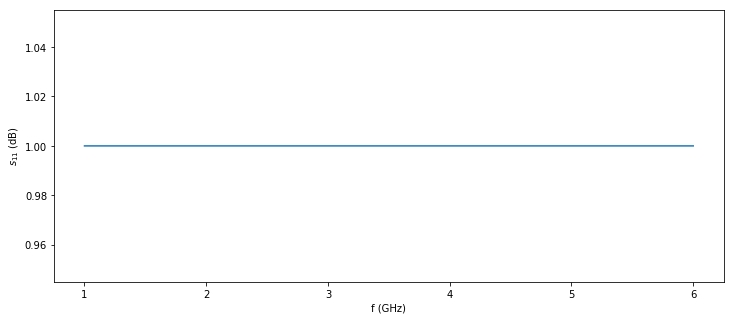

In [15]:
#Choose range of omegas
omegas = np.linspace(1e9,6e9,int(1e5))
s11_values = np.zeros(len(omegas)) 


Z0 = 50

for i in range(len(omegas)):
        s11_values[i] = get_s11(omegas[i],[Si,Ox,Mo],AlN,[Al],Z0,free=True)
        #if (i%(len(omegas)/10))==0:
        #    print(find_Z_in(omegas[i]))
        #since Z_1 is very small compared to 50 ohm, we get only ones. I have to look at all the quantities sitll..
print("min value we found is", np.min(s11_values))
plt.figure(figsize = (12,5))  
plt.plot(omegas/1e9,s11_values)
plt.ylabel("$s_{11}$ (dB)")
plt.xlabel("f (GHz)")    

# The cell below is not useful

In [16]:


#function which takes an arbitrary amount of slabs and a boundary condition state 
#to compute the desired state 
def find_state(slabs,omega,boundary):
    '''
    function which takes in a boundary condition F2,v2 an arbitrary amount of slabs
    to compute the desired state F1,v1
    '''
    #initialize state at site 2
    state = boundary
    
    #loop over all the slabs
    for i in range(len(slabs)):
        #compute the matrix of the ith slab
        Matrix = M(slab[i],omega)
        
        #compute state at site 1 using state at site 2
        state = np.dot(M,state)
        
    return state